In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pre Processing

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import snowballstemmer
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin


In [4]:
train = pd.read_csv('/content/drive/My Drive/AnalyticsVidhya_Tweet_sentiment_Files/train_2kmZucJ.csv')
train.head()
print("Training Set:"% train.columns, train.shape, len(train))
test = pd.read_csv('/content/drive/My Drive/AnalyticsVidhya_Tweet_sentiment_Files/test_oJQbWVk.csv')
print("Test Set:"% test.columns, test.shape, len(test))

Training Set: (7920, 3) 7920
Test Set: (1953, 2) 1953


In [0]:
import re
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df
test_clean = clean_text(test, "tweet")
train_clean = clean_text(train, "tweet")

1    5894
0    5894
Name: label, dtype: int64


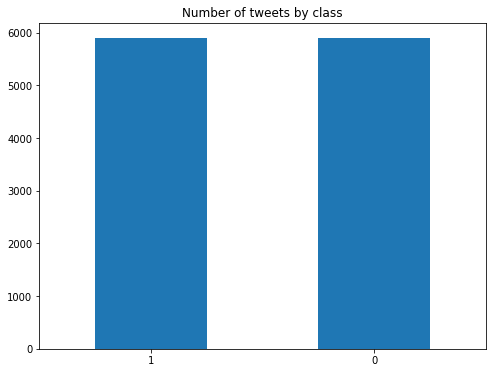

In [6]:
from sklearn.utils import resample
train_majority = train_clean[train_clean.label==0]
train_minority = train_clean[train_clean.label==1]
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),   
                                 random_state=123)
train_upsampled = pd.concat([train_minority_upsampled, train_majority])
print(train_upsampled['label'].value_counts())
train_upsampled['label'].value_counts().plot(kind='bar', figsize=(8, 6), rot=0, legend=False, title='Number of tweets by class');

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_upsampled['tweet'].values, train_upsampled['label'].values, test_size=0.25, random_state=0)

In [0]:
import os, string,re
import snowballstemmer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
stemmer = snowballstemmer.EnglishStemmer()
def tokenize(s): 
    tokens = re_tok.sub(r' \1 ', s).split()
    return stemmer.stemWords(tokens)

In [0]:
vect = TfidfVectorizer(strip_accents='unicode', tokenizer=tokenize, ngram_range=(1, 2), max_df=0.75, min_df=3, sublinear_tf=True)

In [0]:
tfidf_train = vect.fit_transform(X_train)
tfidf_test = vect.transform(X_test)

## Naive Bayes

In [0]:
def naive_bayes(x, y):
    r = []; b = []
    labels = np.unique(y)

    for l in labels:
        other_l = labels[labels != l]
        p = x[y == l].sum(0) + 1
        q = x[(y == other_l[0])].sum(0) + 1
        r.append(np.log((p/p.sum())/(q/q.sum())))
        b.append(np.log(len(p)/len(q)))
    
    return r, b

In [12]:
labels = np.unique(y_train)
for l in labels:
        other_l = labels[labels != l]
        print(other_l)
        print(tfidf_train[y_train == l].sum(0) + 1)

[1]
[[3.7811103  1.         1.         ... 1.         1.26699997 1.        ]]
[0]
[[1.66775981 1.70190564 1.70190564 ... 1.60281969 1.76722426 1.58364953]]


In [0]:
r, b = naive_bayes(tfidf_train, y_train)

pre_preds = []
for j in range(len(r)):
    pre_preds.append(np.asarray(tfidf_test @ r[j].T + b[j]).reshape(-1))
arr = np.array(pre_preds)

In [14]:
print(arr)

[[-2.88811413  0.61146869  1.71023006 ...  4.0941192  -2.68181338
   1.24897768]
 [ 2.88811413 -0.61146869 -1.71023006 ... -4.0941192   2.68181338
  -1.24897768]]


In [15]:
from sklearn import metrics
metrics.accuracy_score(y_test, np.argmax(arr.T, 1))

0.9226331862911435

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
print(metrics.classification_report(y_test, np.argmax(arr.T, 1), target_names=['postive','negative']))

              precision    recall  f1-score   support

     postive       0.96      0.88      0.92      1519
    negative       0.89      0.96      0.92      1428

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.93      0.92      0.92      2947



In [18]:
metrics.f1_score(y_test, np.argmax(arr.T, 1))

0.9234385493619879

In [19]:
tfidf_test_ = vect.transform(test_clean['tweet'])
pre_preds_final = []
for j in range(len(r)):
    pre_preds_final.append(np.asarray(tfidf_test_ @ r[j].T + b[j]).reshape(-1))
arr_final = np.array(pre_preds_final)
np.argmax(arr_final.T, 1)

array([1, 1, 1, ..., 1, 1, 0])

In [0]:
y_predict_final = np.argmax(arr_final.T, 1)
Final_df_nb = pd.DataFrame({'id':test_clean['id'], 'label':y_predict_final})
Final_df_nb.head()
Final_df_nb.to_csv('sample_submission_NB.csv', header=True, index=False)

In [21]:
Final_df_nb['label'].value_counts()

0    1298
1     655
Name: label, dtype: int64